In [1]:
# final project for EE522 DSP
# professor: Dr. James McNames
# author: Nick Porter

# Instructions were to apply filter design theory presented in class.
# I chose to pre-process raw EEG data using HP and savgol filters

from filter_design import PlotSystem
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.signal import freqz
import mne

# define mov avg function to smooth fft output for visualization
def moving_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [2]:
# import data
# using dataset and code from
# https://physionet.org/content/auditory-eeg/1.0.0/

# import dataset
df_raw = pd.read_csv('raw_seg/s01_ex01_s01.csv')
df_fil = pd.read_csv('filter_seg/s01_ex01_s01.csv')

dfs = df_raw
print(df_raw.head())
print("raw length = %d" % len(df_raw))
print(df_fil.head())
print("fil length = %d" % len(df_fil))

   Unnamed: 0          T7           F8          Cz          P4
0        9000  533.956726 -1017.742737  434.163116  345.218933
1        9001  516.659729 -1034.703125  421.286652  339.302429
2        9002  521.615051 -1031.969238  432.577393  335.192261
3        9003  548.441345 -1010.782776  452.522278  344.815033
4        9004  537.386230 -1029.429932  443.662476  348.222076
raw length = 24000
   Unnamed: 0        P4         Cz        F8         T7
0        9000  0.363670   1.737014 -4.067892   0.381685
1        9001  1.431664  13.112759  1.608346   9.416291
2        9002  3.898135  18.654392  3.684386  15.530512
3        9003  5.212464  17.267150 -0.361015  14.671486
4        9004  4.956096  14.274596 -3.350014  11.456772
fil length = 24000


In [3]:
# define dimensions and data channels
fs = 200      # Hz
ts = 1/fs
N = len(dfs)
t = np.arange(0,N*ts,ts)
dfs['Time (s)'] = t
df = dfs[['Time (s)','T7','F8','Cz','P4']]

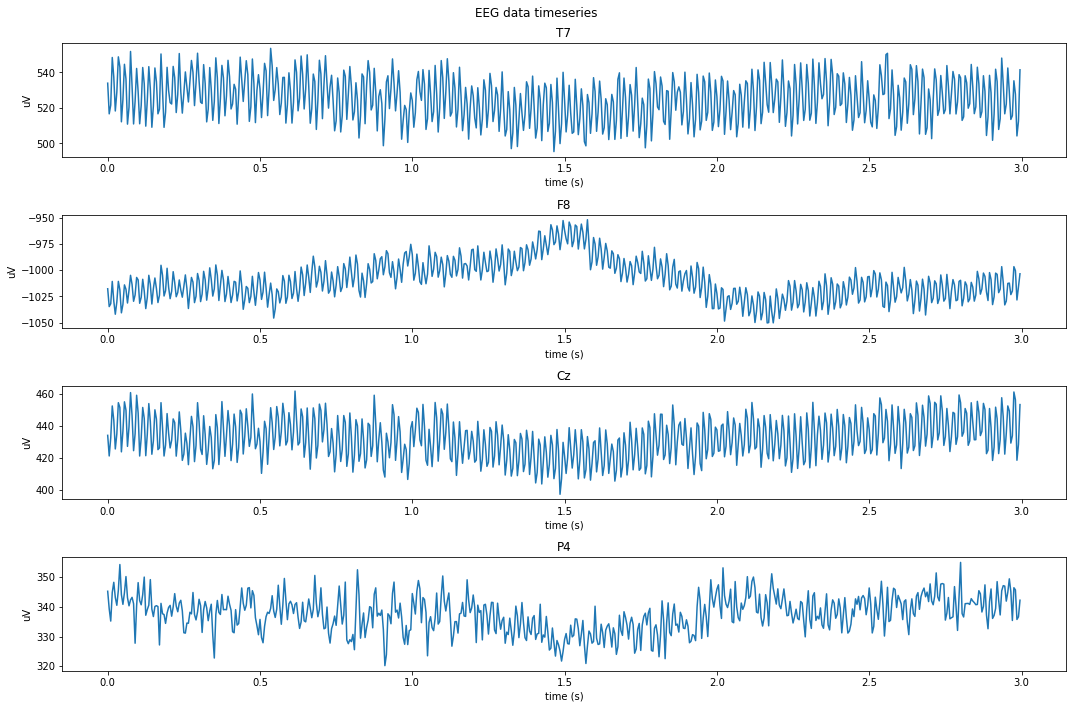

In [4]:
# create dict of data to plot
column = ['T7','F8','Cz','P4']
plotnum = len(column)
datad = {}
for col in column:
    datad[col] = df[col].values

# plot raw data
plotlen = N//40
fig, axs = plt.subplots(plotnum,1,figsize=(15, 10), sharex=True)
for key,ax in zip(datad,axs):
    ax.plot(t[:plotlen],datad[key][:plotlen])
    ax.tick_params(axis='both', which='both', labelbottom=True)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('uV')
    ax.set_title(key)

# show plots
fig.suptitle('EEG data timeseries')
plt.tight_layout()
plt.show()

In [5]:
# create dict of transformed data to plot
data_fft = {}
for key in datad:
    data_fft[key] = 20*np.log10(abs(scipy.fft.fft(datad[key])))
    
for key in data_fft:
    v = np.zeros(N)
    g = moving_avg(data_fft[key],20)
    if len(g) <= N:
        v[:len(g)] = g
    else:
        v = g[:N]
    data_fft[key] = v

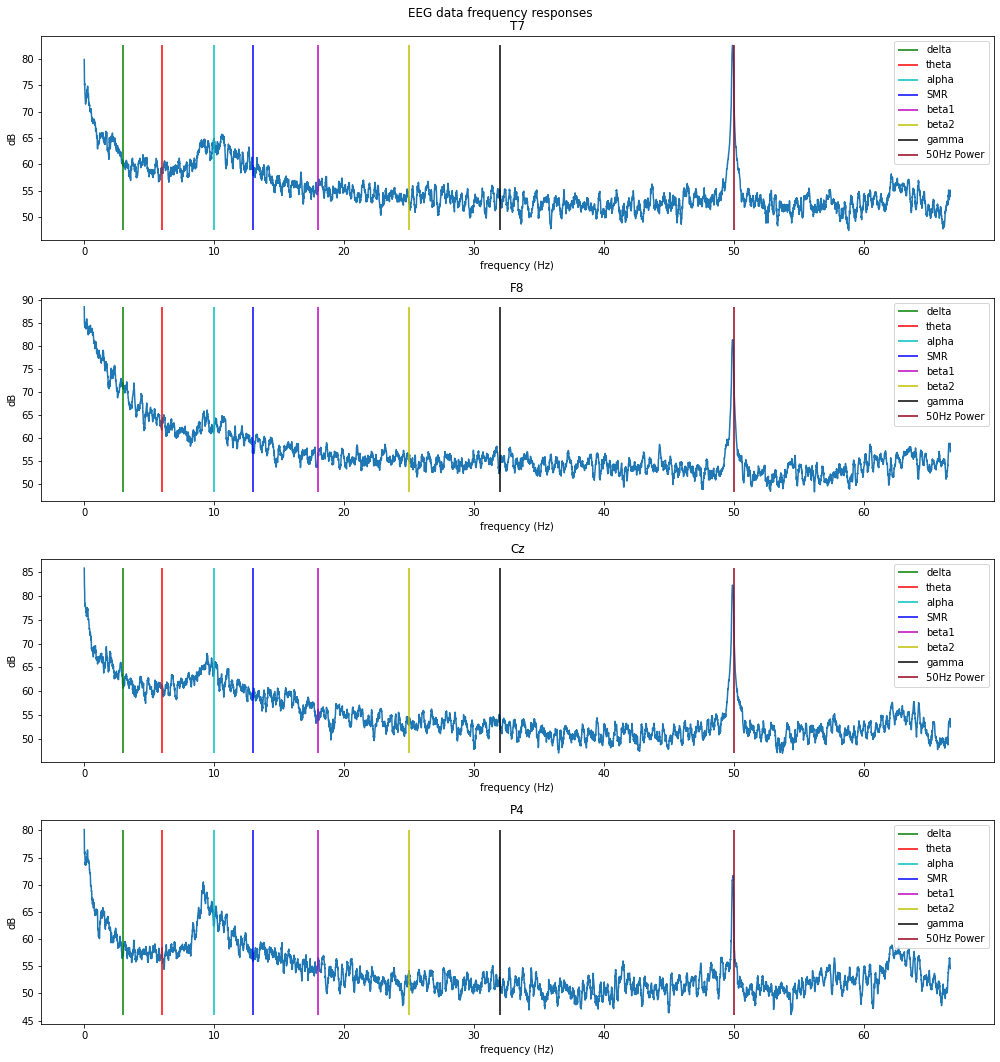

In [6]:
# plot freq responses of data in dB
f = np.linspace(0,fs,N)
plotlen = N//3
plotnum = len(column)

# vlines info
bfreqs = [3,6,10,13,18,25,32,50]
bf_labels = ['delta','theta','alpha','SMR','beta1','beta2','gamma','50Hz Power']
colors = ['g','r','c','b','m','y','k','#960018']

# plot data
fig, axs = plt.subplots(plotnum,1,figsize=(14, 15), sharex=True)
for key,ax in zip(data_fft,axs):
    ax.plot(f[:plotlen],data_fft[key][:plotlen])
    ax.set_title(key)
    ax.set_xlabel('frequency (Hz)')
    ax.tick_params(axis='both', which='both', labelbottom=True)
    ax.set_ylabel('dB')
    lo,hi = [min(data_fft[key][:plotlen]),max(data_fft[key][:plotlen])]
    for line,lab,col in zip(bfreqs,bf_labels,colors):
        ax.vlines(line, lo, hi, colors=col, label=lab)
    ax.legend(loc='upper right')

# show plots
fig.suptitle('EEG data frequency responses')
plt.tight_layout()
plt.show()

Setting up high-pass filter at 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 331 samples (1.655 sec)



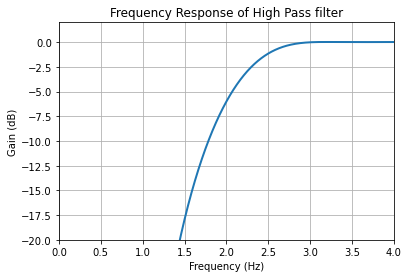

In [7]:
# design a high pass filter with cutoff = 3Hz
cutoff = 3      # Hz
#numtaps = 101

# Estimate the filter coefficients.
#taps = scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=False, fs=fs)
taps = mne.filter.create_filter(data=datad['F8'], sfreq=fs, l_freq=cutoff, h_freq=None, filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', method='fir', iir_params=None, phase='zero', fir_window='hamming', fir_design='firwin', verbose=None)

w, h = freqz(taps, worN=N)

plt.plot((w/np.pi)*(fs//2), 20*np.log10(np.abs(h)), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.title('Frequency Response of High Pass filter')
plt.ylim(-20, 2)
plt.xlim(0,4)
plt.grid(True)
plt.show()

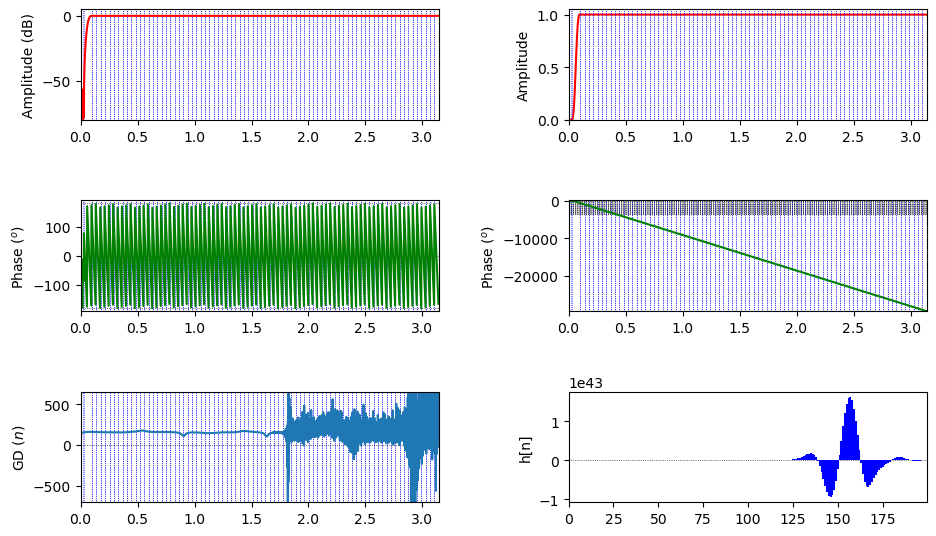

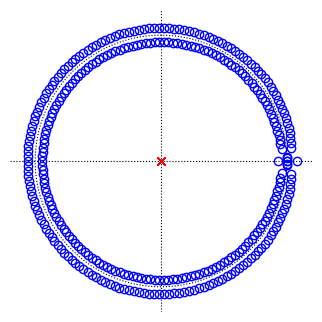

In [8]:
# filter as system
b = taps
a = 1.0
sos = scipy.signal.tf2sos(b,a)

# Use custom filter design function written by Dr. McNames
gd = PlotSystem(sos)

In [9]:
# turn system group delay into integer
# able to do this because linear, constant phase of filter
print(gd)
delay = gd[1:]
print(delay)
delay = int(round(delay[3]))
print(delay)

[  0.         150.47497327 150.47709105 ... 641.2173916  444.3827252
 291.24993272]
[150.47497327 150.47709105 150.48062001 ... 641.2173916  444.3827252
 291.24993272]
150


In [10]:
# modify input to help edge conditions
data_pad = {}
for key in datad:
    data_pad[key] = np.pad(datad[key],delay,'reflect')
    
# create dict of highpass filtered data
data_HP = {}
for key in data_pad:
    data_HP[key] = np.convolve(taps,data_pad[key],'same')
    
# remove mirrored edges
data_fil = {}
for key in data_HP:
    data_fil[key] = data_HP[key][delay:N+delay]

# create dict of fft filtered data
data_HP_fft = {}
for key in data_fil:
    data_HP_fft[key] = 20*np.log10(abs(scipy.fft.fft(data_fil[key])))
    
# moving avg of fft
for key in data_HP_fft:
    v = np.zeros(N)
    g = moving_avg(data_HP_fft[key],20)
    if len(g) <= N:
        v[:len(g)] = g
    else:
        v = g[:N]
    data_HP_fft[key] = v

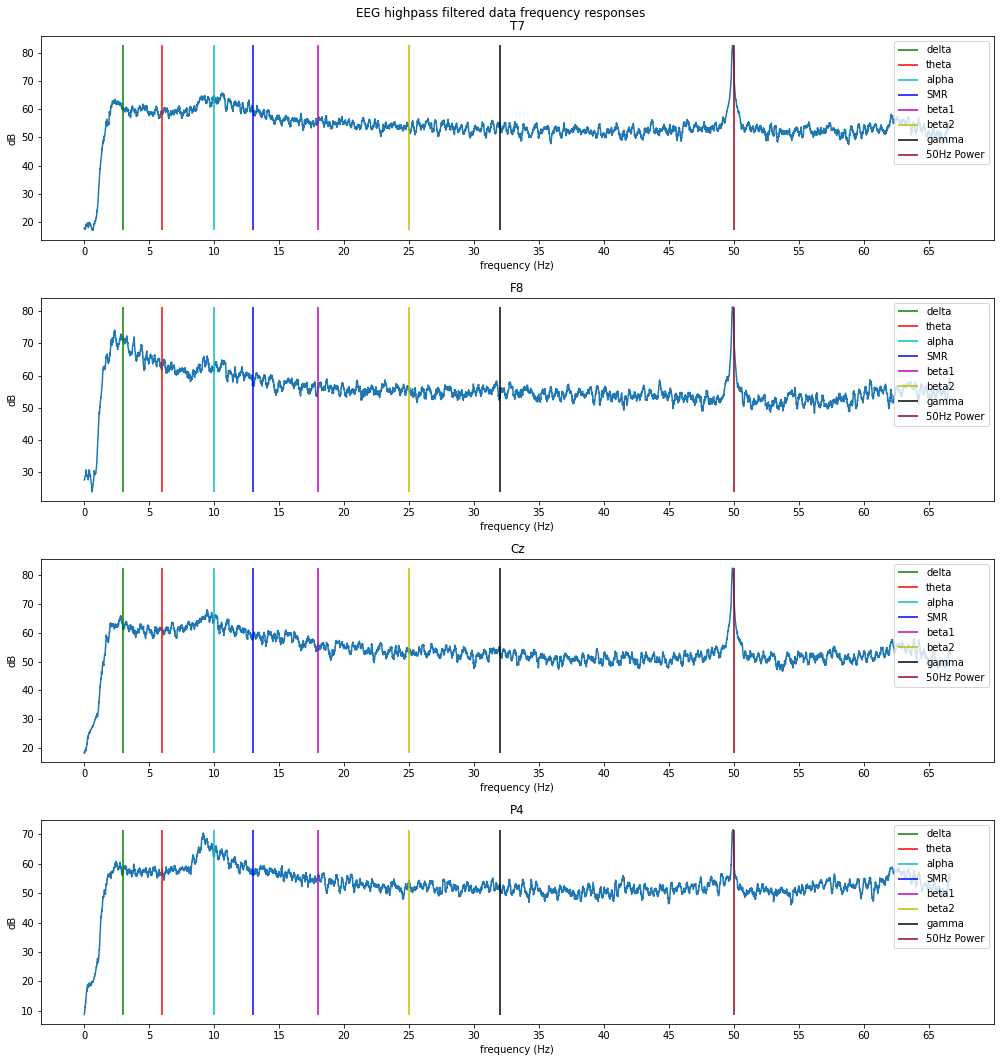

In [11]:
# plot freq responses of highpass filtered data in dB
f = np.linspace(0,fs,N)
plotlen = N//3
plotnum = len(column)

# vlines info
bfreqs = [3,6,10,13,18,25,32,50]
bf_labels = ['delta','theta','alpha','SMR','beta1','beta2','gamma','50Hz Power']
colors = ['g','r','c','b','m','y','k','#960018']

# plot data
fig, axs = plt.subplots(plotnum,1,figsize=(14, 15), sharex=True)
for key,ax in zip(data_HP_fft,axs):
    ax.plot(f[:plotlen],data_HP_fft[key][:plotlen])
    ax.set_title(key)
    ax.set_xlabel('frequency (Hz)')
    ax.tick_params(axis='both', which='both', labelbottom=True)
    ax.set_xticks(np.arange(min(f), max(f)+1, 5))
    ax.set_ylabel('dB')
    lo,hi = [min(data_HP_fft[key][:plotlen]),max(data_HP_fft[key][:plotlen])]
    for line,lab,col in zip(bfreqs,bf_labels,colors):
        ax.vlines(line, lo, hi, colors=col, label=lab)
    ax.legend(loc='upper right')

# show plots
fig.suptitle('EEG highpass filtered data frequency responses')
plt.tight_layout()
plt.show()

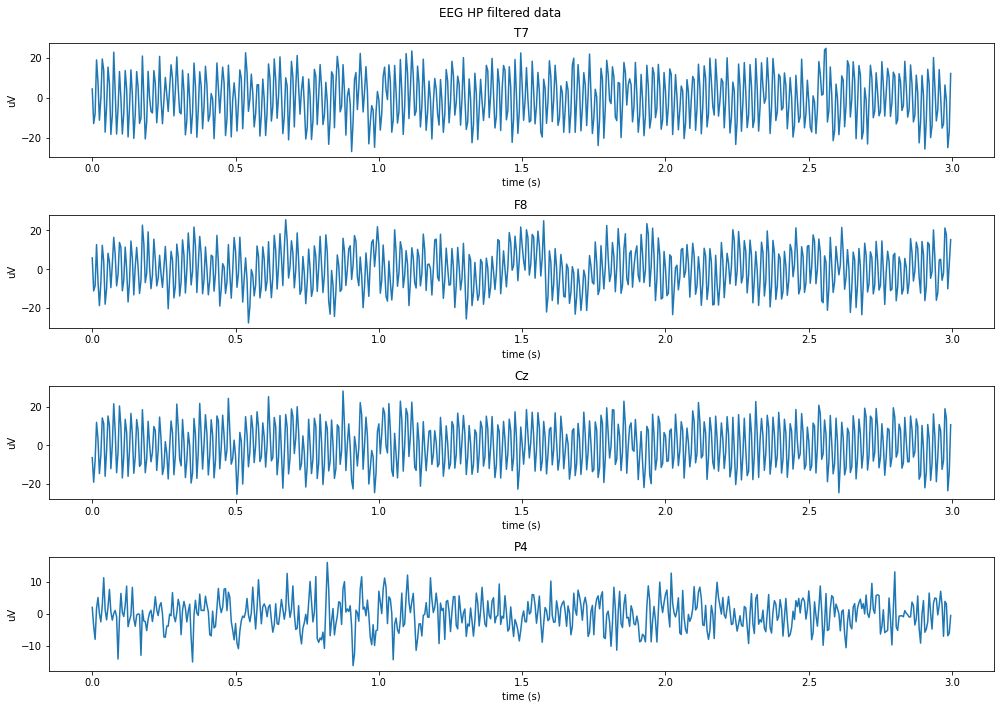

In [12]:
# plot filtered timeseries data
plotlen = N//40
plotnum = len(column)

fig, axs = plt.subplots(plotnum,1,figsize=(14, 10), sharex=True)
for key,ax in zip(data_fil,axs):
    ax.plot(t[:plotlen],data_fil[key][:plotlen])
    ax.set_title(key)
    ax.tick_params(axis='both', which='both', labelbottom=True)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('uV')

# show plots
fig.suptitle('EEG HP filtered data')
plt.tight_layout()
plt.show()

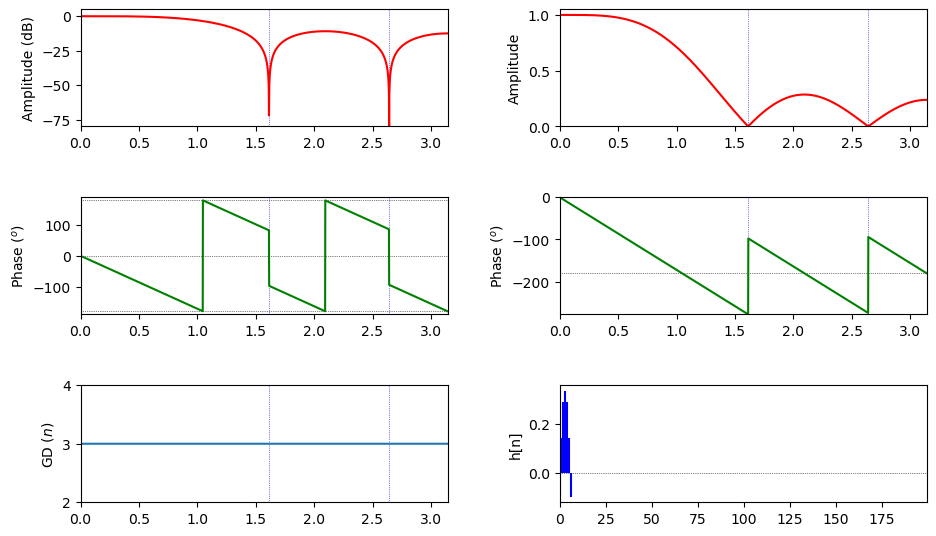

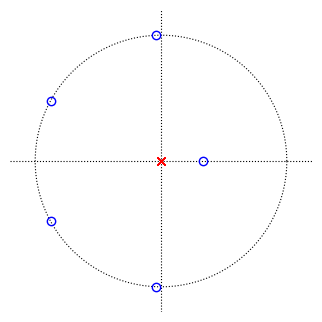

In [13]:
# use savgol filter
# coefficients of savgol filter
M = 7     # length
k = 3     # poly order
d = 0     # derivative order
c = scipy.signal.savgol_coeffs(M, k, deriv=d, delta=1.0, pos=None, use='conv')

# use a bs fir instead
#M = 11
#k = 5
#cutoff = [46, 54]
#c = scipy.signal.firwin(M, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=fs)

# filter as system
b = c
a = 1.0
sos = scipy.signal.tf2sos(b,a)

# Use custom filter design function written by Dr. McNames
gd = PlotSystem(sos)

[0. 3. 3. ... 3. 3. 3.]
[3. 3. 3. ... 3. 3. 3.]
3


Text(0, 0.5, 'Coefficient value')

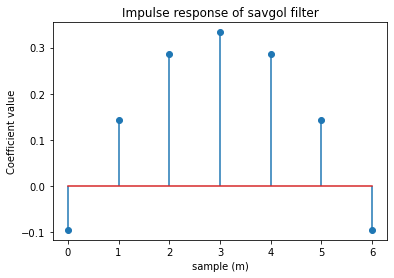

In [14]:
# turn system group delay into integer
# able to do this because linear, constant phase of filter
print(gd)
delay = gd[1:]
print(delay)
delay = int(round(delay[3]))
print(delay)
plt.stem(c)
plt.title('Impulse response of savgol filter')
plt.xlabel('sample (m)')
plt.ylabel('Coefficient value')

In [15]:
# modify input to help edge conditions
data_pad2 = {}
for key in data_fil:
    data_pad2[key] = np.pad(data_fil[key],delay,'reflect')
    
# create dict of savgol filtered data
data_savgol = {}
for key in data_pad2:
    data_savgol[key] = np.convolve(c,data_pad2[key],'same')
    
data_fil2 = {}
for key in data_savgol:
    data_fil2[key] = data_savgol[key][M:N+M]

# create dict of fft filtered data
data_savgol_fft = {}
for key in data_savgol:
    data_savgol_fft[key] = 20*np.log10(abs(scipy.fft.fft(data_savgol[key])))
    #data_savgol_fft[key] = abs(scipy.fft.fft(data_savgol[key]))

for key in data_savgol_fft:
    v = np.zeros(N)
    g = moving_avg(data_savgol_fft[key],20)
    if len(g) <= N:
        v[:len(g)] = g
    else:
        v = g[:N]
    data_savgol_fft[key] = v

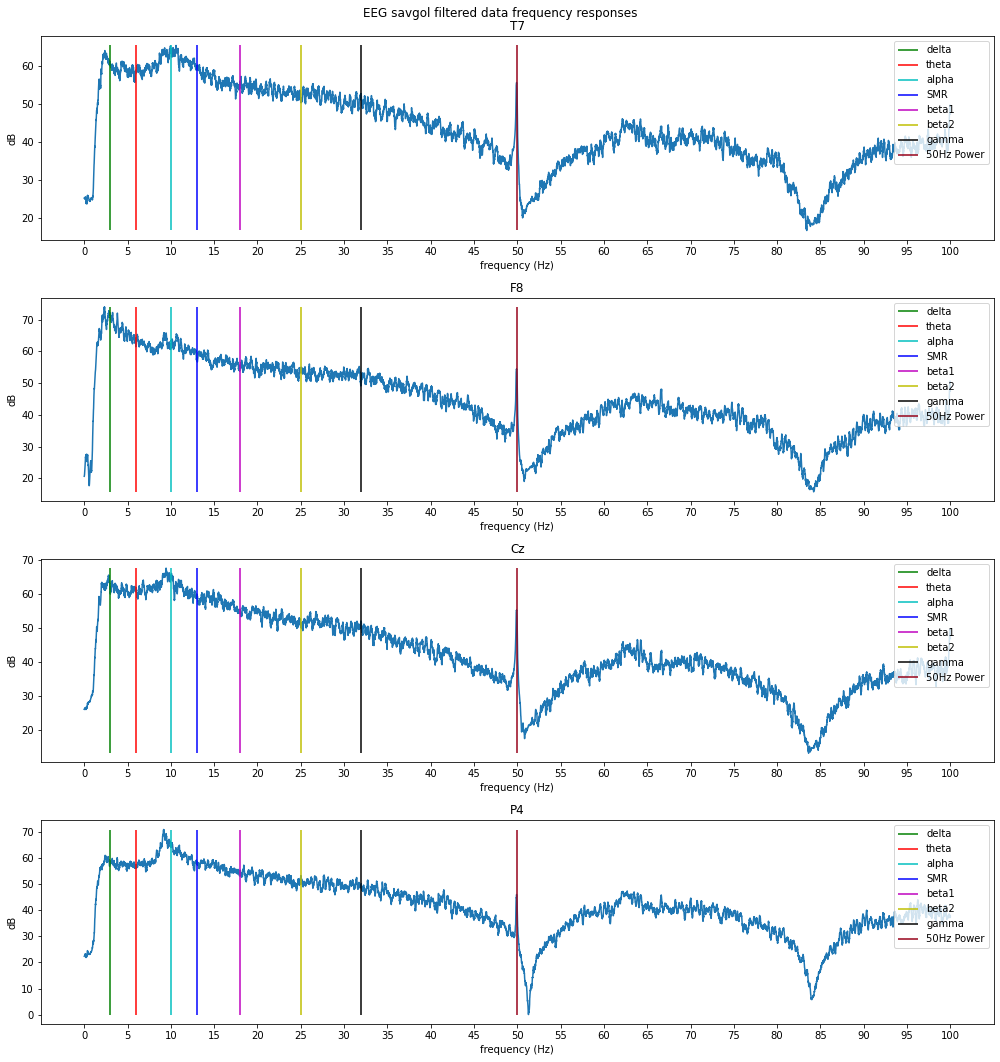

In [16]:
# plot freq responses of savgol filtered data in dB
f = np.linspace(0,fs,N)
plotlen = N//2
plotnum = len(column)

# vlines info
bfreqs = [3,6,10,13,18,25,32,50]
bf_labels = ['delta','theta','alpha','SMR','beta1','beta2','gamma','50Hz Power']
colors = ['g','r','c','b','m','y','k','#960018']

# plot data
fig, axs = plt.subplots(plotnum,1,figsize=(14, 15), sharex=True)
for key,ax in zip(data_savgol_fft,axs):
    ax.plot(f[:plotlen],data_savgol_fft[key][:plotlen])
    ax.set_title(key)
    ax.set_xlabel('frequency (Hz)')
    ax.tick_params(axis='both', which='both', labelbottom=True)
    ax.set_xticks(np.arange(min(f), max(f)+1, 5))
    ax.set_ylabel('dB')
    lo,hi = [min(data_savgol_fft[key][:plotlen]),max(data_savgol_fft[key][:plotlen])]
    for line,lab,col in zip(bfreqs,bf_labels,colors):
        ax.vlines(line, lo, hi, colors=col, label=lab)
    ax.legend(loc='upper right')

# show plots
fig.suptitle('EEG savgol filtered data frequency responses')
plt.tight_layout()
plt.show()

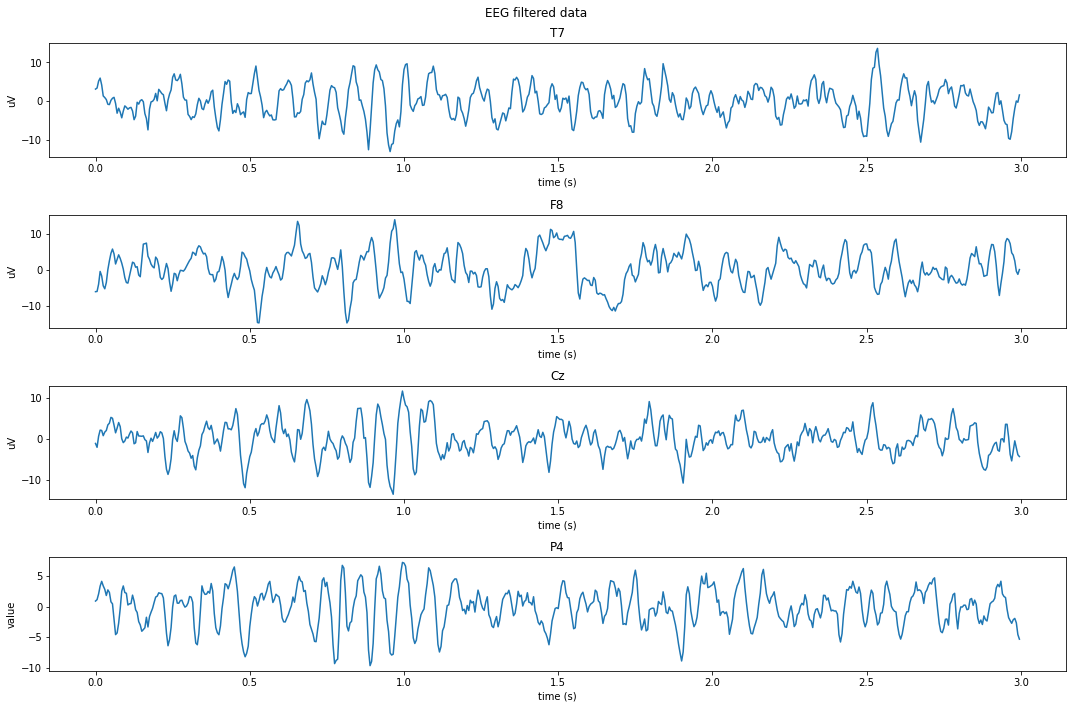

In [17]:
# plot filtered timeseries data
plotlen = N//40
plotnum = len(column)

fig, axs = plt.subplots(plotnum,1,figsize=(15, 10), sharex=True)
for key,ax in zip(data_fil2,axs):
    ax.plot(t[:plotlen],data_fil2[key][:plotlen])
    ax.set_title(key)
    ax.tick_params(axis='both', which='both', labelbottom=True)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('uV')

# show plots
fig.suptitle('EEG filtered data')
plt.xlabel('time (s)')
plt.ylabel('value')
plt.tight_layout()
plt.show()

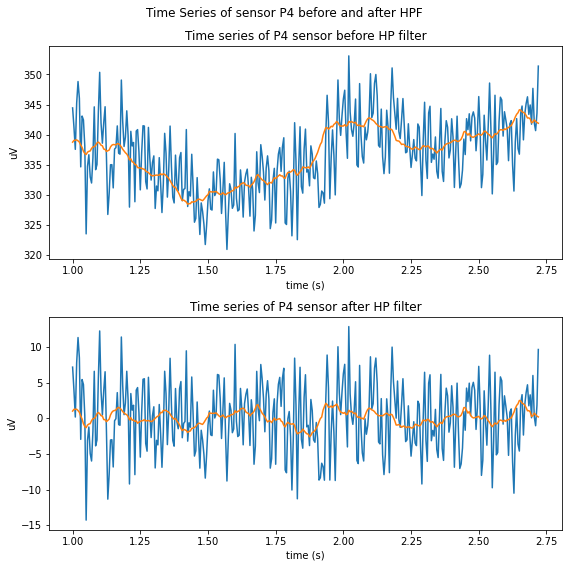

In [18]:
# aggregated plots for the paper

# Figure 4
# plot raw data time series against HP time series
plotstart = 200
plotlen = N//44
plotnum = 2

x1_mavg = moving_avg(datad['P4'],20)
x2_mavg = moving_avg(data_fil['P4'],20)

fig, [ax1,ax2] = plt.subplots(plotnum,1,figsize=(8, 8), sharex=True)
fig.suptitle('Time Series of sensor P4 before and after HPF')

ax1.plot(t[plotstart:plotlen],datad['P4'][plotstart:plotlen])
ax1.plot(t[plotstart:plotlen],x1_mavg[plotstart:plotlen])
ax1.set_title('Time series of P4 sensor before HP filter')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('uV')
ax1.tick_params(axis='both', which='both', labelbottom=True)

ax2.plot(t[plotstart:plotlen],data_fil['P4'][plotstart:plotlen])
ax2.plot(t[plotstart:plotlen],x2_mavg[plotstart:plotlen])
ax2.set_title('Time series of P4 sensor after HP filter')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('uV')
ax2.tick_params(axis='both', which='both', labelbottom=True)

plt.tight_layout()

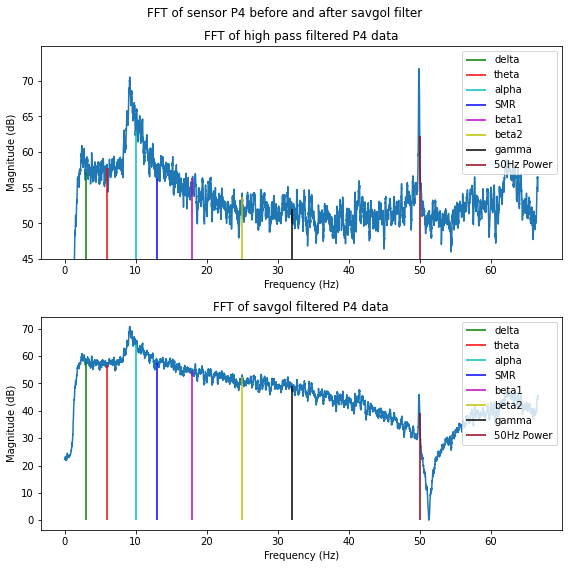

In [19]:
# Figure 6
# plot HP data fft against savgol fft
plotstart = 0
plotlen = N//3
plotnum = 2

# vlines info
bfreqs = [3,6,10,13,18,25,32,50]
bf_labels = ['delta','theta','alpha','SMR','beta1','beta2','gamma','50Hz Power']
colors = ['g','r','c','b','m','y','k','#960018']

fig, [ax1,ax2] = plt.subplots(plotnum,1,figsize=(8, 8), sharex=True)
fig.suptitle('FFT of sensor P4 before and after savgol filter')

ax1.set_title('FFT of high pass filtered P4 data')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.tick_params(axis='both', which='both', labelbottom=True)
ax1.plot(f[plotstart:plotlen],data_HP_fft['P4'][plotstart:plotlen])
ax1.set_ylim(bottom=45)
for line,lab,col in zip(bfreqs,bf_labels,colors):
    ax1.vlines(line, lo, data_HP_fft['P4'][int(round((line/(fs//2)) * 12000))], colors=col, label=lab)
    
ax2.set_title('FFT of savgol filtered P4 data')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.tick_params(axis='both', which='both', labelbottom=True)
ax2.plot(f[plotstart:plotlen],data_savgol_fft['P4'][plotstart:plotlen])
lo,hi = [min(data_savgol_fft[key][:plotlen]),max(data_savgol_fft[key][:plotlen])]
for line,lab,col in zip(bfreqs,bf_labels,colors):
    ax2.vlines(line, lo, data_savgol_fft['P4'][int(round((line/(fs//2)) * 12000))], colors=col, label=lab)
    
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.tight_layout()

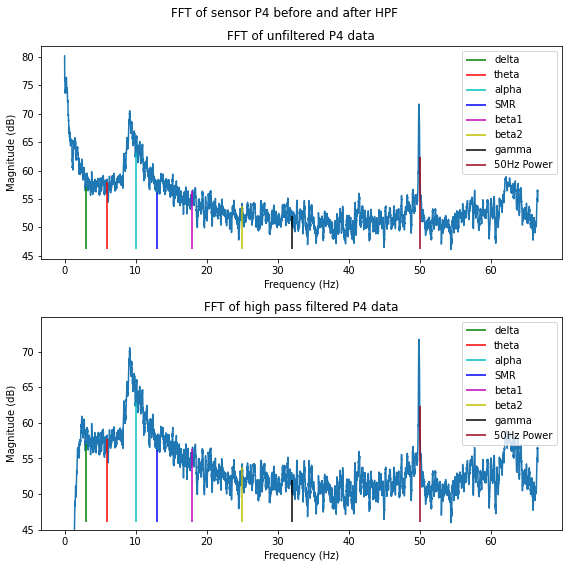

In [20]:
# Figure 5
# plot raw data fft against HP fft
plotstart = 0
plotlen = N//3
plotnum = 2

# vlines info
bfreqs = [3,6,10,13,18,25,32,50]
bf_labels = ['delta','theta','alpha','SMR','beta1','beta2','gamma','50Hz Power']
colors = ['g','r','c','b','m','y','k','#960018']

fig, [ax1,ax2] = plt.subplots(plotnum,1,figsize=(8, 8), sharex=True)
fig.suptitle('FFT of sensor P4 before and after HPF')

ax1.set_title('FFT of unfiltered P4 data')
ax1.plot(f[plotstart:plotlen],data_fft['P4'][plotstart:plotlen])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.tick_params(axis='both', which='both', labelbottom=True)
lo,hi = [min(data_fft[key][:plotlen]),max(data_fft[key][:plotlen])]
for line,lab,col in zip(bfreqs,bf_labels,colors):
    ax1.vlines(line, lo, data_fft['P4'][int(round((line/(fs//2)) * 12000))], colors=col, label=lab)
    
ax2.set_title('FFT of high pass filtered P4 data')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.tick_params(axis='both', which='both', labelbottom=True)
ax2.plot(f[plotstart:plotlen],data_HP_fft['P4'][plotstart:plotlen])
ax2.set_ylim(bottom=45)
for line,lab,col in zip(bfreqs,bf_labels,colors):
    ax2.vlines(line, lo, data_HP_fft['P4'][int(round((line/(fs//2)) * 12000))], colors=col, label=lab)
    
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.tight_layout()

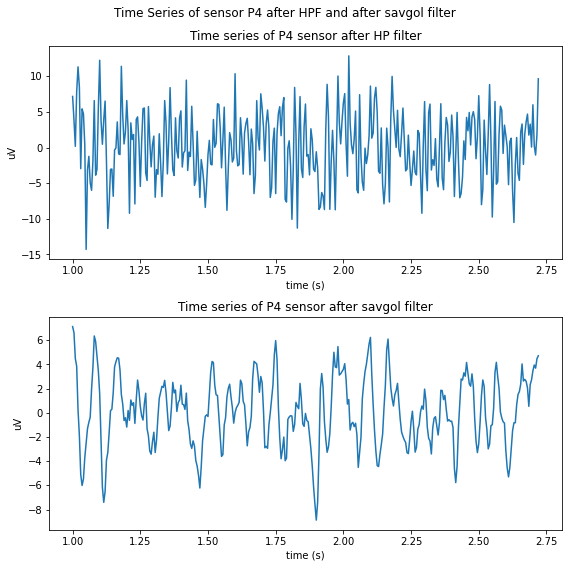

In [21]:
# Figure 7
# plot HP time series against savgol time series
plotstart = 200
plotlen = N//44
plotnum = 2

x1_mavg = moving_avg(data_fil['P4'],20)
x2_mavg = moving_avg(data_fil2['P4'],20)

fig, [ax1,ax2] = plt.subplots(plotnum,1,figsize=(8, 8), sharex=True)
fig.suptitle('Time Series of sensor P4 after HPF and after savgol filter')

ax1.plot(t[plotstart:plotlen],data_fil['P4'][plotstart:plotlen])
#ax1.plot(t[plotstart:plotlen],x1_mavg[plotstart:plotlen])
ax1.set_title('Time series of P4 sensor after HP filter')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('uV')
ax1.tick_params(axis='both', which='both', labelbottom=True)

ax2.plot(t[plotstart:plotlen],data_fil2['P4'][plotstart:plotlen])
#ax2.plot(t[plotstart:plotlen],x2_mavg[plotstart:plotlen])
ax2.set_title('Time series of P4 sensor after savgol filter')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('uV')
ax2.tick_params(axis='both', which='both', labelbottom=True)

plt.tight_layout()